In [2]:
# Importing Python lybraries

import yfinance as yf # Public yahooh finance API.
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import acf, pacf, adfuller, q_stat
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scipy.stats import normaltest, skew, kurtosis, chi2, norm

from arch.univariate import ARX, GARCH, arch_model

# diasble warnings

import warnings
warnings.filterwarnings('ignore')

statsmodels documentation

\url{https://www.statsmodels.org/stable/tsa.html#descriptive-statistics-and-tests}

arch documentation

\url{https://arch.readthedocs.io/en/latest/univariate/univariate.html}

yahoo finance documentation

\url{https://python-yahoofinance.readthedocs.io/en/latest/api.html}

\url{https://www.nasdaq.com/market-activity/stocks/screener} (lauch it on google, with safari apparently leads to a different web page, don't know why)



## Anlysis of univariate time series

In [3]:
# Importing time series from yahoo finance

msft = yf.Ticker("MSFT") # Get the ticker for stock Microsoft
msft_hist = msft.history(period="10y") # get historical time series correspondig the ticker. 10y = ten years

print(msft_hist.head())

                                Open       High        Low      Close  \
Date                                                                    
2014-05-27 00:00:00-04:00  34.271070  34.271070  33.888013  34.211483   
2014-05-28 00:00:00-04:00  34.168902  34.211463  33.896504  34.058239   
2014-05-29 00:00:00-04:00  34.177414  34.347660  33.973115  34.339149   
2014-05-30 00:00:00-04:00  34.432803  34.875450  34.262554  34.849911   
2014-06-02 00:00:00-04:00  34.858413  34.977586  34.628576  34.722214   

                             Volume  Dividends  Stock Splits  
Date                                                          
2014-05-27 00:00:00-04:00  26160600        0.0           0.0  
2014-05-28 00:00:00-04:00  25711500        0.0           0.0  
2014-05-29 00:00:00-04:00  19888200        0.0           0.0  
2014-05-30 00:00:00-04:00  34567600        0.0           0.0  
2014-06-02 00:00:00-04:00  18504300        0.0           0.0  


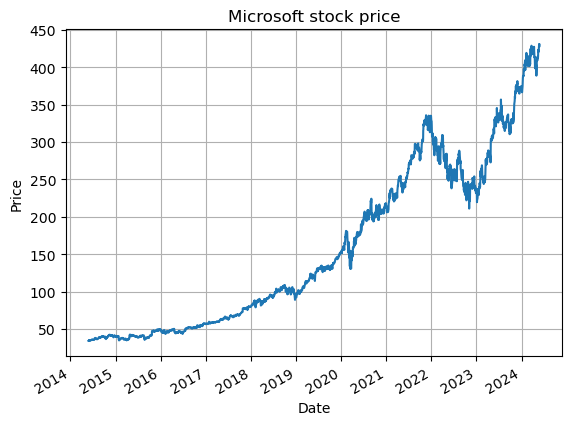

In [4]:
msft_hist['Close'].plot()
plt.grid()
plt.title('Microsoft stock price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

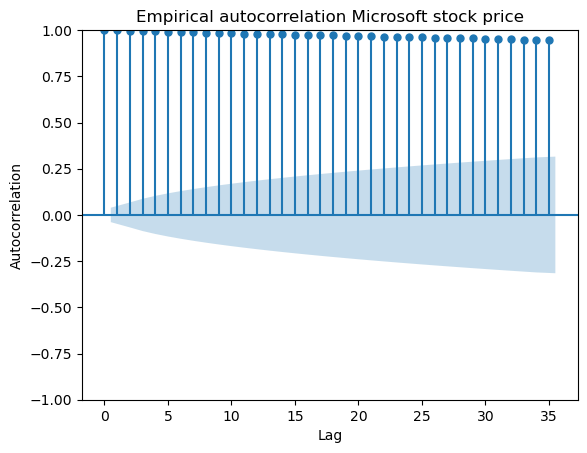

In [5]:
# Let's check the autocorrelation of the price time series

microsoft_price_acf = plot_acf(np.array(msft_hist['Close']))
plt.title('Empirical autocorrelation Microsoft stock price')
plt.ylabel('Autocorrelation')
plt.xlabel('Lag')
plt.show()

In [6]:
# Let's check the stationarity of the time series

ad_fuller_test  = adfuller(np.array(msft_hist['Close'])) # It's a tuple
ad_fuller_statistic = ad_fuller_test[0]
ad_fuller_pvalue = ad_fuller_test[1]

layout = '{0:>25}{1:>20}{2:>20}'
print(layout.format('Test', 'Statistic', 'P-Value'))
print(layout.format('AD-Fuller test', np.round(ad_fuller_statistic, 5), np.round(ad_fuller_pvalue, 5)))


                     Test           Statistic             P-Value
           AD-Fuller test             1.18555             0.99588


From the pvalue the test strongly rejects the null hypothesis of stationarity. So given the non stationarity of the time series we analyse the log-returns of the series. $$ r_t = \log\left(\frac{P_{t}}{P_{t-1}}\right) $$

In [7]:
microsft_log_returns = np.log(msft_hist['Close']).diff()
microsft_log_returns = microsft_log_returns.dropna()

print(microsft_log_returns.head(10))

Date
2014-05-28 00:00:00-04:00   -0.004489
2014-05-29 00:00:00-04:00    0.008214
2014-05-30 00:00:00-04:00    0.014764
2014-06-02 00:00:00-04:00   -0.003671
2014-06-03 00:00:00-04:00   -0.012333
2014-06-04 00:00:00-04:00    0.000744
2014-06-05 00:00:00-04:00    0.021834
2014-06-06 00:00:00-04:00    0.006531
2014-06-09 00:00:00-04:00   -0.005076
2014-06-10 00:00:00-04:00   -0.003884
Name: Close, dtype: float64


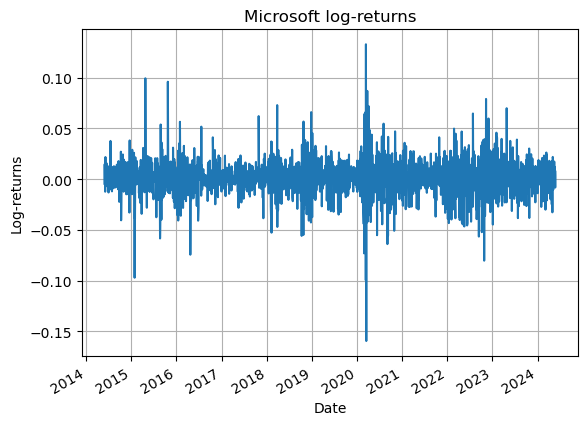

In [8]:
microsft_log_returns.plot()
plt.grid()
plt.title('Microsoft log-returns')
plt.xlabel('Date')
plt.ylabel('Log-returns')
plt.show()

In [9]:
# Descriptive statistics
microsof_logret_mean = np.mean(np.array(microsft_log_returns))
microsof_logret_standar_dev = np.std(np.array(microsft_log_returns))
microsof_logret_skewness = skew(np.array(microsft_log_returns))
microsof_logret_kurtosis = kurtosis(np.array(microsft_log_returns))

layout = '{0:>20}{1:>25}{2:>20}{3:>20}'
print(layout.format('Mean', 'Standar Deviation', 'Skewness', 'Kurtosis'))
print(layout.format(np.round(microsof_logret_mean ,5), np.round(microsof_logret_standar_dev ,5), np.round(microsof_logret_skewness ,5), np.round(microsof_logret_kurtosis ,5)))


                Mean        Standar Deviation            Skewness            Kurtosis
             0.00101                  0.01701            -0.15187             8.18306


### Let's test, for autocorrelation, stationarity and normality of the data

In [10]:
# Stationarity
ad_fuller_test  = adfuller(np.array(microsft_log_returns))
ad_fuller_statistic = ad_fuller_test[0]
ad_fuller_pvalue = ad_fuller_test[1]

layout = '{0:>25}{1:>20}{2:>20}'
print(layout.format('Test', 'Statistic', 'P-Value'))
print(layout.format('AD-Fuller test', np.round(ad_fuller_statistic, 5), np.round(ad_fuller_pvalue, 5)))

                     Test           Statistic             P-Value
           AD-Fuller test           -17.42818                 0.0


Now we accept the null hypothesis of the AD-Fuller test. So, we can fit models and perform statistical tests

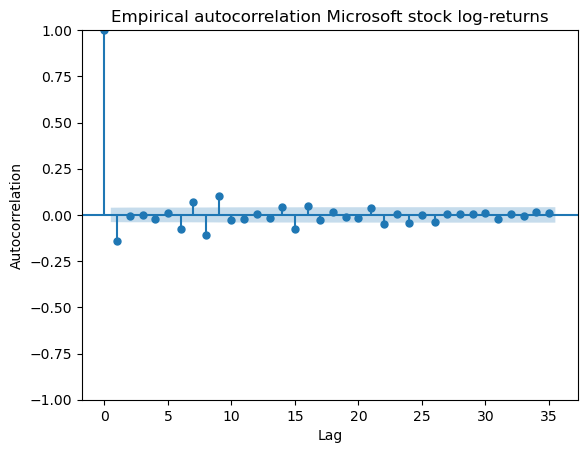

In [11]:
# Autocorrelation function

microsoft_price_acf = plot_acf(np.array(microsft_log_returns))
plt.title('Empirical autocorrelation Microsoft stock log-returns')
plt.ylabel('Autocorrelation')
plt.xlabel('Lag')
plt.show()

Even though for some points the series overcomes the Bartlet bounds we clearly see that the series is ergodic since it loses memory in the long run. Then, the time series is ergodic and stationary, which means that the assumpions to apply a central limit theorem are valid. 

### Some tricks to check the presence of dependence:

Let $X$ and $Y$ be two random variables, they are independent if $$ \mathbb{E}[XY] = \mathbb{E}[X]\mathbb{E}[Y]$$ Then for any measurable functions $f$ and $g$, we have that $$ \mathbb{E}[f(X)g(Y)] = \mathbb{E}[f(X)]\mathbb{E}[g(Y)].$$ Let $f=g=x^2$, $X=X_t$ and $Y=X_{t-h}$ if the $X_{t}$ and $X_{t-h}$ are independent, then also $X_t^2$ and $X_{t-h}^2$ shold be independent as weel, which implies $$ \mathbb{COV}[X_t^2 X_{t-h}^2] = 0$$

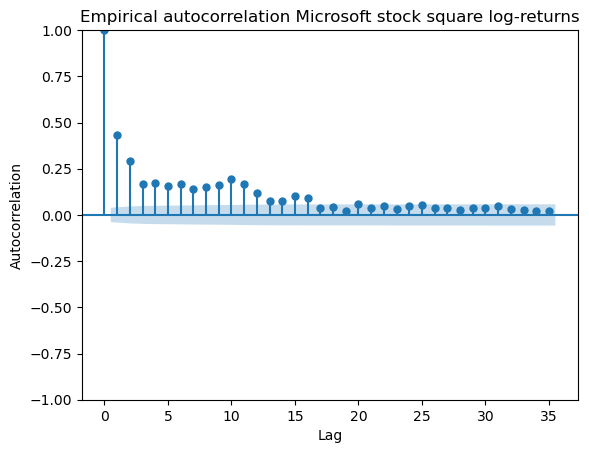

In [12]:
# Autocorrelation function of the squares

microsoft_price_acf = plot_acf(np.array(microsft_log_returns)**2)
plt.title('Empirical autocorrelation Microsoft stock square log-returns')
plt.ylabel('Autocorrelation')
plt.xlabel('Lag')
plt.show()

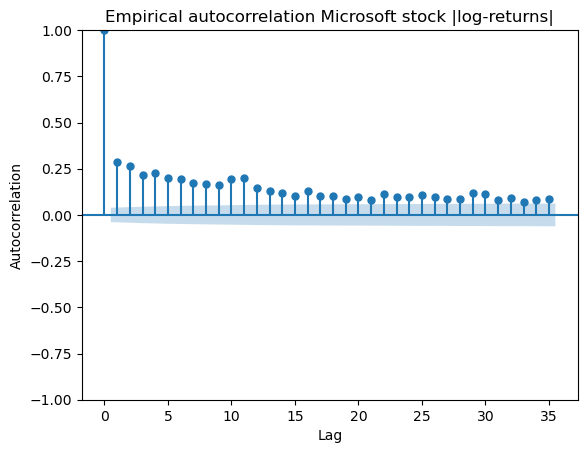

In [13]:
# Autocorrelation function of the squares

microsoft_price_acf = plot_acf(np.abs(np.array(microsft_log_returns)))
plt.title('Empirical autocorrelation Microsoft stock |log-returns|')
plt.ylabel('Autocorrelation')
plt.xlabel('Lag')
plt.show()

So in both case of $f=g=x^2$ and $f=g=|x|$ the empirical autocorrelation function detects quite a long memory for the process. Considering the fact that $$ \mathbb{COV}[X_t X_{t-h}] \approx 0$$ this could be a sign of the presence of stochastic volatility 

### Assessing the existence of the moments of the distribution

Let's recall the following version of the Law of Larga Numbers:
Let $(X_t)_{t\geq0}$ be a sequence of random variables s.t.:

_ $\mathbb{E}[X_t] = \mu < +\infty$

_ $|\mathbb{COV}(X_t,X_s)| \leq c p^{|t-s|} + 
\infty$ with $p\in(0,1)$

Then, $\frac{1}{T}\sum_{t=1}^T X_t \rightarrow \mu$ in probability as $T\rightarrow +\infty$


(The proof is left to the diligent student). Hint: Use the Markov inequality.

The meaning of the previous theorem is that, even in the case of correlated random variables you may have consistent estimators.

In [14]:
# Lets check the convergence for the mean 

X_t = np.array(microsft_log_returns)

est_mean = np.empty(len(X_t)-30)
est_variance = np.empty(len(X_t)-30)
est_skewness = np.empty(len(X_t)-30)
est_kurtosis = np.empty(len(X_t)-30)

N = np.arange(30, len(X_t))


for i in range(30,len(X_t)):
    
    est_mean[i-30] = np.mean(X_t[:i])
    est_variance[i-30] = np.var(X_t[:i])
    est_skewness[i-30] = skew(X_t[:i])
    est_kurtosis[i-30] = kurtosis(X_t[:i])
    




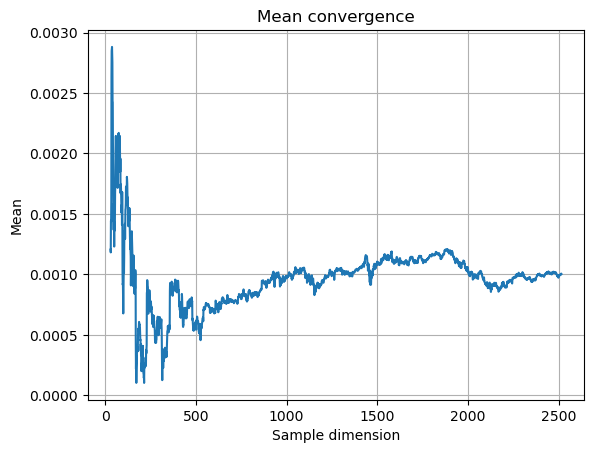

In [15]:
plt.plot(N, est_mean)
plt.title('Mean convergence')
plt.xlabel('Sample dimension')
plt.ylabel('Mean')
plt.grid()
plt.show()

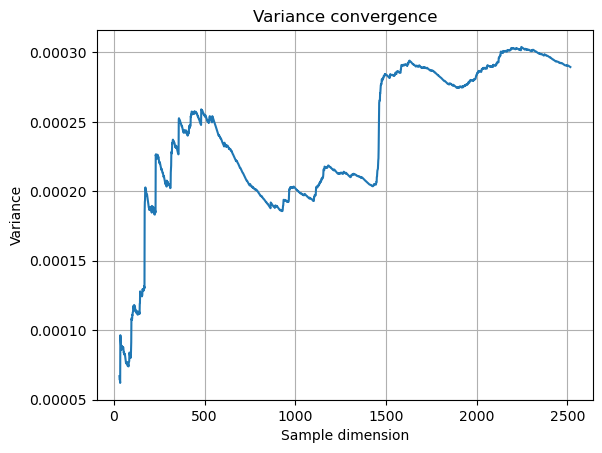

In [16]:
plt.plot(N, est_variance)
plt.title('Variance convergence')
plt.xlabel('Sample dimension')
plt.ylabel('Variance')
plt.grid()
plt.show()

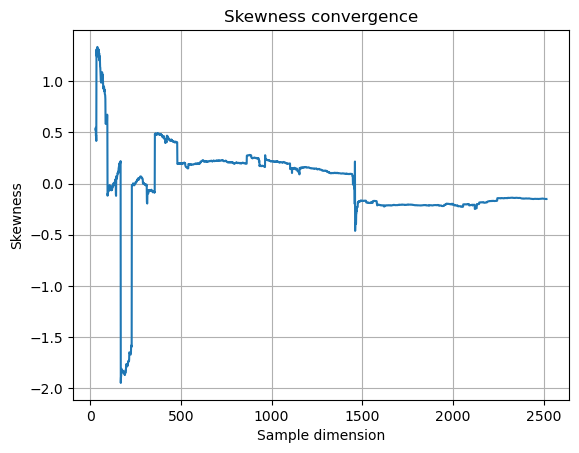

In [17]:
plt.plot(N, est_skewness)
plt.title('Skewness convergence')
plt.xlabel('Sample dimension')
plt.ylabel('Skewness')
plt.grid()
plt.show()

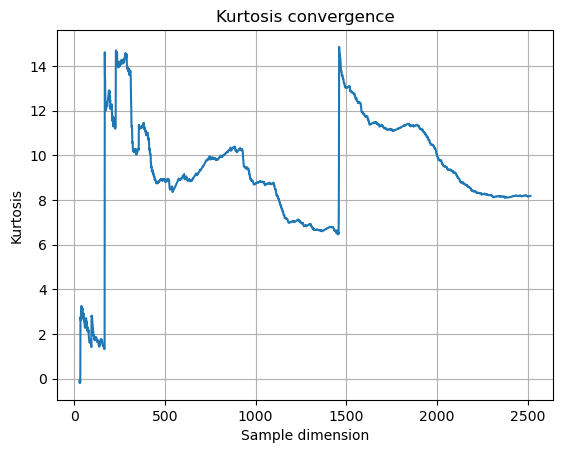

In [18]:
plt.plot(N, est_kurtosis)
plt.title('Kurtosis convergence')
plt.xlabel('Sample dimension')
plt.ylabel('Kurtosis')
plt.grid()
plt.show()

We clearly see that all the moments tentd to converge as the sample dimension increases, showning a non exploding behaviour of the moments. 

In [19]:
# Test for normality

microsoft_logret_normal_statistic, microsoft_logret_normal_pval = normaltest(np.array(microsft_log_returns))

layout = '{0:>30}{1:>20}{2:>20}'
print(layout.format('Test','Statistic','P-Value'))
print(layout.format("D'Agostino's K-squared test", np.round(microsoft_logret_normal_statistic, 5), np.round(microsoft_logret_normal_pval ,5)))

                          Test           Statistic             P-Value
   D'Agostino's K-squared test           408.63899                 0.0


The test strongly rejects the null hypothesis of normally distributed data.

## Fitting GARCH models within  the arch python library 

Remark:

The Python library arch is based on the object oriented programming (OOP) 

### GARCH(1,1) model

In [20]:
# Let's begins with the standard GARCH(1,1) model

vol_model = GARCH(p=1, q=1) # defining the volatility process 
microsoft_garch11 = arch_model(y=microsft_log_returns); # creating the arch_model object
microsoft_garch11.volatility = vol_model # setting the volatility instance for the object microsoft_garch11

# Fitting GARCH(1,1)

fit_microsoft_garch11 = microsoft_garch11.fit(update_freq=5)
print(fit_microsoft_garch11.summary())

Iteration:      5,   Func. Count:     48,   Neg. LLF: -6537.591004737758
Iteration:     10,   Func. Count:     81,   Neg. LLF: -6840.098281593904
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6964.265798363625
            Iterations: 14
            Function evaluations: 97
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6964.27
Distribution:                  Normal   AIC:                          -13920.5
Method:            Maximum Likelihood   BIC:                          -13897.2
                                        No. Observations:                 2517
Date:                Mon, May 27 2024   Df Residuals:                     2516
Time:       

In [21]:
# Extrating parameters, pvalues and loglikelihood

microsoft_garch11_params = fit_microsoft_garch11.params # it's a Pandas series object
microsoft_garch11_pvalues = fit_microsoft_garch11.pvalues # it's a Pandas series object
microsoft_garch11_loglike = fit_microsoft_garch11.loglikelihood # it's a float

print('Log-likelihood : ' + str(np.round(microsoft_garch11_loglike, 5)))
print()

estimates_microsoft_garch11 = pd.concat([microsoft_garch11_params, microsoft_garch11_pvalues], axis=1)
print(estimates_microsoft_garch11)

Log-likelihood : 6964.2658

            params        pvalues
mu        0.001281   2.472051e-06
omega     0.000021   0.000000e+00
alpha[1]  0.169620   4.518238e-06
beta[1]   0.765231  5.596033e-152


The p-values of the T-test show that all the parameters are statistically significant since they all reject the null hypothesis of being zero

Text(0.5, 0.98, 'Microsoft')

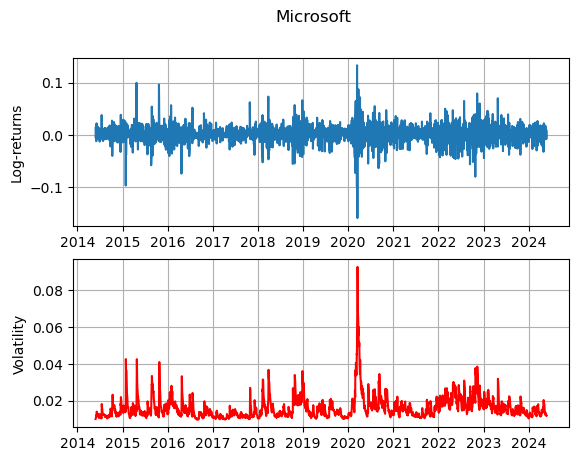

In [22]:
# Extracting conditional volatility

microsoft_garch11_volatility = fit_microsoft_garch11._volatility # volatility time series. It's a numpy array

fig, axs = plt.subplots(2) 
axs[0].plot(microsft_log_returns)
axs[0].grid()
# axs[0].set_xlabel('Date')
axs[0].set_ylabel('Log-returns')
axs[1].plot(microsft_log_returns.index, microsoft_garch11_volatility, 'r')
axs[1].grid()
# axs[1].set_xlabel('Date')
axs[1].set_ylabel('Volatility')
fig.suptitle('Microsoft')

In [23]:
microsoft_garch11_resid = fit_microsoft_garch11.resid # residuals time series. It's a numpy array

# Let's test if the residuals are Gaussian or not.

microsoft_resid_garch11_normal_statistic, microsoft_resid_garch11_normal_pval = normaltest(np.array(microsoft_garch11_resid))

layout = '{0:>30}{1:>20}{2:>20}'
print(layout.format('Test','Statistic','P-Value'))
print(layout.format("D'Agostino's K-squared test", np.round(microsoft_resid_garch11_normal_statistic, 5), np.round(microsoft_resid_garch11_normal_pval ,5)))


                          Test           Statistic             P-Value
   D'Agostino's K-squared test           408.63899                 0.0


The null hypothesis is rejected. 

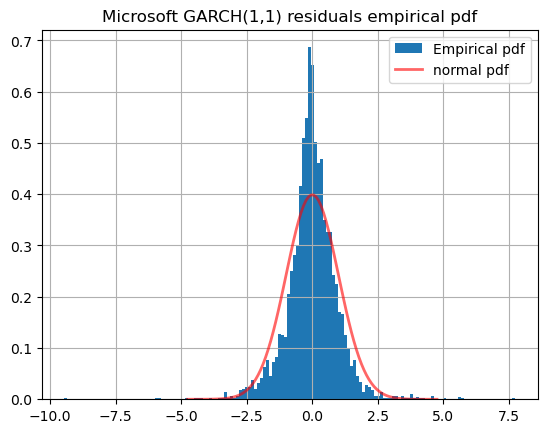

In [24]:
plt.hist(microsoft_garch11_resid/np.std(microsoft_garch11_resid), density=True, bins=150, label='Empirical pdf')
plt.grid()
plt.title('Microsoft GARCH(1,1) residuals empirical pdf')
x = np.linspace(norm.ppf(0.000001), norm.ppf(0.999999), 100)
plt.plot(x, norm.pdf(x), 'r-', lw=2, alpha=.6, label='normal pdf')
plt.legend()
plt.show()

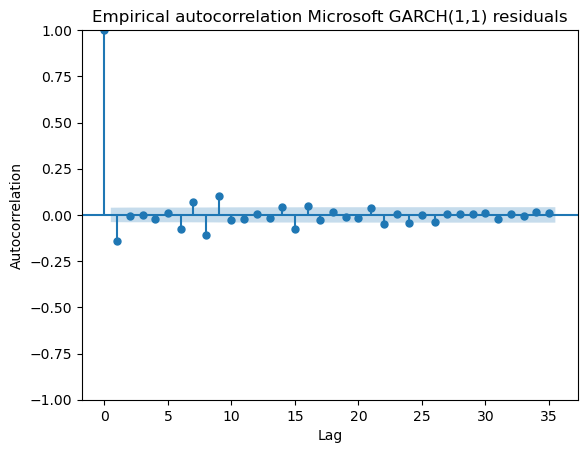

In [25]:
# Let's check the autocorrelation of residuals

microsoft_price_acf = plot_acf(microsoft_garch11_resid)
plt.title('Empirical autocorrelation Microsoft GARCH(1,1) residuals')
plt.ylabel('Autocorrelation')
plt.xlabel('Lag')
plt.show()

### AR(1)-GARCH(1,1)

In [27]:
microsoft_ar1garch11 = arch_model(y=microsft_log_returns, mean='AR', lags=1); # creating the arch_model object with AR(1) conditional mean process
microsoft_ar1garch11.volatility = vol_model # setting the volatility instance for the object microsoft_garch11

# Fitting AR(1)-GARCH(1,1)

fit_microsoft_ar1garch11 = microsoft_ar1garch11.fit(update_freq=5)
print(fit_microsoft_ar1garch11.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6957.151546793057
            Iterations: 4
            Function evaluations: 53
            Gradient evaluations: 4
                           AR - GARCH Model Results                           
Dep. Variable:                  Close   R-squared:                       0.018
Mean Model:                        AR   Adj. R-squared:                  0.018
Vol Model:                      GARCH   Log-Likelihood:                6957.15
Distribution:                  Normal   AIC:                          -13904.3
Method:            Maximum Likelihood   BIC:                          -13875.2
                                        No. Observations:                 2516
Date:                Mon, May 27 2024   Df Residuals:                     2514
Time:                        11:58:10   Df Model:                            2
                                 Mean Model                                 
    

In [28]:
# Extrating parameters, pvalues and loglikelihood

microsoft_ar1garch11_params = fit_microsoft_ar1garch11.params # it's a Pandas series object
microsoft_ar1garch11_pvalues = fit_microsoft_ar1garch11.pvalues # it's a Pandas series object
microsoft_ar1garch11_loglike = fit_microsoft_ar1garch11.loglikelihood # it's a float
microsoft_ar1garch11_r2 = fit_microsoft_ar1garch11._r2 # it's a float

print('Log-likelihood : ' + str(np.round(microsoft_ar1garch11_loglike, 5)))
print()

print('R-squared : ' + str(np.round(microsoft_ar1garch11_r2, 5)))
print()

estimates_microsoft_ar1garch11 = pd.concat([microsoft_ar1garch11_params, microsoft_ar1garch11_pvalues], axis=1)
print(estimates_microsoft_ar1garch11)

Log-likelihood : 6957.15155

R-squared : 0.01795

            params        pvalues
Const     0.001759   8.970860e-10
Close[1] -0.131484   1.305465e-06
omega     0.000028  2.357349e-109
alpha[1]  0.199996   1.076871e-09
beta[1]   0.700007  1.785140e-134


Again, the p-values of the T-test show that all the parameters are statistically significant since they all reject the null hypothesis of being zero. 

Text(0.5, 0.98, 'Microsoft')

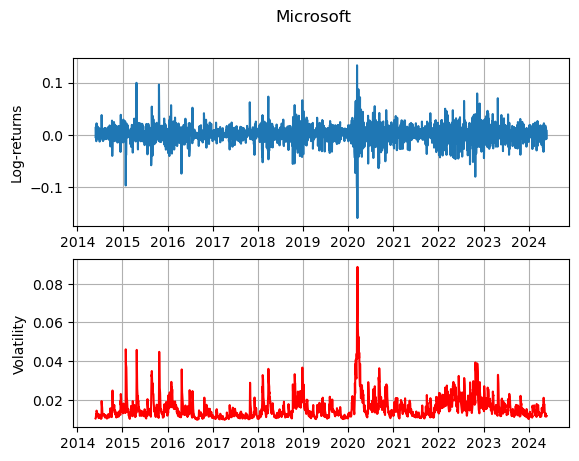

In [29]:
# Extracting conditional volatility

microsoft_ar1garch11_volatility = fit_microsoft_ar1garch11._volatility # volatility time series. It's a numpy array

fig, axs = plt.subplots(2) 
axs[0].plot(microsft_log_returns)
axs[0].grid()
# axs[0].set_xlabel('Date')
axs[0].set_ylabel('Log-returns')
axs[1].plot(microsft_log_returns.index, microsoft_ar1garch11_volatility, 'r')
axs[1].grid()
# axs[1].set_xlabel('Date')
axs[1].set_ylabel('Volatility')
fig.suptitle('Microsoft')

In [30]:
microsoft_ar1garch11_resid = fit_microsoft_ar1garch11.resid # residuals time series. It's a numpy array
microsoft_ar1garch11_resid = microsoft_ar1garch11_resid[~np.isnan(microsoft_ar1garch11_resid)]
# Let's test if the residuals are Gaussian or not.

microsoft_resid_ar1garch11_normal_statistic, microsoft_resid_ar1garch11_normal_pval = normaltest(np.array(microsoft_ar1garch11_resid))

layout = '{0:>30}{1:>20}{2:>20}'
print(layout.format('Test','Statistic','P-Value'))
print(layout.format("D'Agostino's K-squared test", np.round(microsoft_resid_ar1garch11_normal_statistic, 5), np.round(microsoft_resid_ar1garch11_normal_pval ,5)))


                          Test           Statistic             P-Value
   D'Agostino's K-squared test           371.55295                 0.0


The null hypothesis is rejected. 

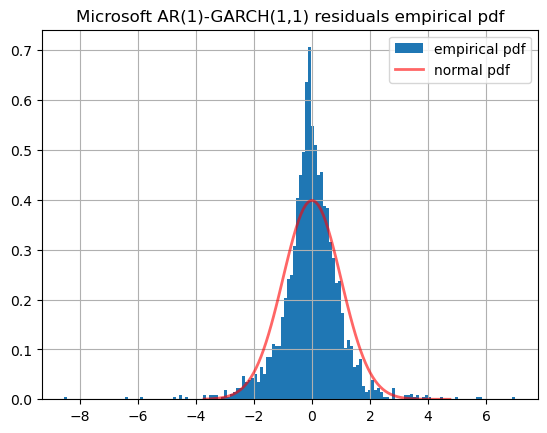

In [31]:
plt.hist(microsoft_ar1garch11_resid/np.std(microsoft_ar1garch11_resid), density=True, bins=150, label='empirical pdf')
plt.grid()
x = np.linspace(norm.ppf(0.0001), norm.ppf(0.999999), 100)
plt.plot(x, norm.pdf(x), 'r-', lw=2, alpha=.6, label='normal pdf')
plt.title('Microsoft AR(1)-GARCH(1,1) residuals empirical pdf')
plt.legend()
plt.show()

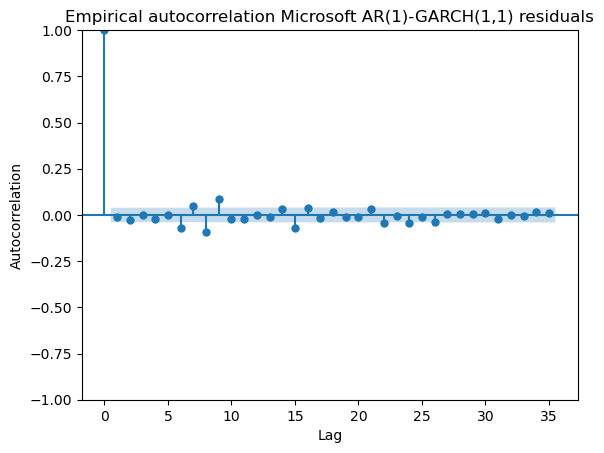

In [32]:
# Let's check the autocorrelation of residuals

microsoft_price_acf = plot_acf(microsoft_ar1garch11_resid)
plt.title('Empirical autocorrelation Microsoft AR(1)-GARCH(1,1) residuals')
plt.ylabel('Autocorrelation')
plt.xlabel('Lag')
plt.show()

### How can we choose between the two models ?

To compare the two mmodels in this case we can use a Likelihood-Ratio test since the two models are nested. Let $LR$ be the likelihood ratio statistic, then:

$$ LR = -2(\log(loglike_1) - \log(loglike_2)) \sim \chi^2(\nu) $$

Where $loglike_1$ is the loglikelihood associated to the model with $n_1$ parameters and $loglike_2$ is the loglikelihood associated to the model with $n_2$ parameters with $n_2>n_1$, and $\nu=n_2-n_1$.

In [34]:
# Let's comapare the two models
LR_stat = -2 * (microsoft_garch11_loglike - microsoft_ar1garch11_loglike)
nu = len(estimates_microsoft_ar1garch11) - len(estimates_microsoft_garch11)
LR_pval = chi2.sf(LR_stat, nu)

print('LR p-val : ', str(LR_pval))

LR p-val :  1.0


So the test doesn't reject the null hypothesis for which the model with more parameters is better than the model with less parameters.